In [1]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt

# Download dataset


In [3]:
!gdown --id 1-8UrAsreTpYezl2z58xdg8v6ab2BbYmu

Downloading...
From: https://drive.google.com/uc?id=1-8UrAsreTpYezl2z58xdg8v6ab2BbYmu
To: /content/stanford-car-dataset-by-classes-folder.zip
1.96GB [00:21, 93.0MB/s]


In [4]:
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

# Create generator
https://keras.io/api/preprocessing/image/

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE=(224,224)
BATCH_SIZE=32

train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.xception.preprocess_input,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '/content/car_data/car_data/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.xception.preprocess_input,
)

test_generator = test_datagen.flow_from_directory(
    '/content/car_data/car_data/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


# Define and train models

In [ ]:
base_model = keras.applications.xception.Xception(input_shape=(224, 224, 3),
                                                  include_top=False,
                                                  pooling='avg',
                                                  weights=None)

last_out = base_model.layers[-1].output
x = keras.layers.Dense(196, activation='softmax')(last_out)

model = keras.Model(base_model.input, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

model.summary()

history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=30)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

# Feature Extraction

In [ ]:
base_model = keras.applications.xception.Xception(input_shape=(224, 224, 3),
                                                  include_top=False,
                                                  pooling='avg',
                                                  weights='imagenet')
base_model.trainable = False
last_out = base_model.layers[-1].output
x = keras.layers.Dense(196, activation='softmax')(last_out)

model = keras.Model(base_model.input, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

model.summary()

history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=30)

83689472/83683744 [==============================] - 10s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

Grad

#Fine Tuning

In [ ]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt

base_model = keras.applications.xception.Xception(input_shape=(224, 224, 3),
                                                  include_top=False,
                                                  pooling='avg',
                                                  weights='imagenet')
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
  if layer.name == 'block14_sepconv1':
    set_trainable = True

  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

last_out = base_model.layers[-1].output
x = keras.layers.Dense(196, activation='softmax')(last_out)

model = keras.Model(base_model.input, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

model.summary()

history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=30)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

#Grad-CAM + Fine Tuning

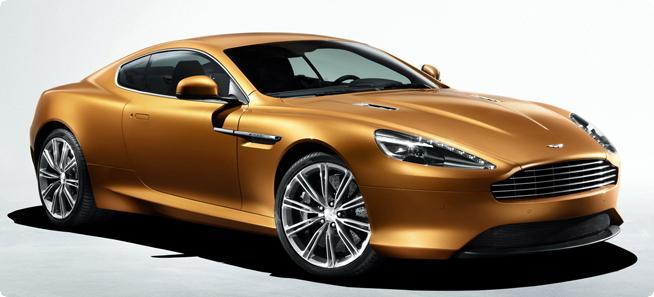

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


model_builder = keras.applications.xception.Xception
img_size = (229, 229)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
#img_path = keras.utils.get_file(
#   "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
#)
img_path = "/content/car_data/car_data/test/Aston Martin Virage Coupe 2012/00757.jpg"

display(Image(img_path))



In [7]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))



In [8]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model

base_model = keras.applications.xception.Xception(input_shape=(229, 229, 3),
                                                  include_top=False,
                                                  pooling='avg',
                                                  weights='imagenet')
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
  if layer.name == 'block14_sepconv1':
    set_trainable = True

  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

# Remove last layer's softmax
base_model.layers[-1].activation = None

last_out = base_model.layers[-1].output
x = keras.layers.Dense(196, activation='softmax')(last_out)

model = keras.Model(base_model.input, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

#model.summary()
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=30)


83689472/83683744 [==============================] - 0s 0us/step
Epoch 1/30
255/255 [==============================] - 252s 851ms/step - loss: 4.4055 - accuracy: 0.1003 - val_loss: 2.8649 - val_accuracy: 0.2918
Epoch 2/30
255/255 [==============================] - 213s 836ms/step - loss: 1.8290 - accuracy: 0.5241 - val_loss: 2.3787 - val_accuracy: 0.4083
Epoch 3/30
255/255 [==============================] - 211s 827ms/step - loss: 1.0518 - accuracy: 0.7114 - val_loss: 1.9169 - val_accuracy: 0.4987
Epoch 4/30
255/255 [==============================] - 210s 825ms/step - loss: 0.6475 - accuracy: 0.8179 - val_loss: 2.0169 - val_accuracy: 0.5016
Epoch 5/30
255/255 [==============================] - 210s 823ms/step - loss: 0.4330 - accuracy: 0.8777 - val_loss: 2.1722 - val_accuracy: 0.5030
Epoch 6/30
255/255 [==============================] - 209s 821ms/step - loss: 0.3098 - accuracy: 0.9166 - val_loss: 1.7783 - val_accuracy: 0.5671
Epoch 7/30
255/255 [==============================] - 209s 

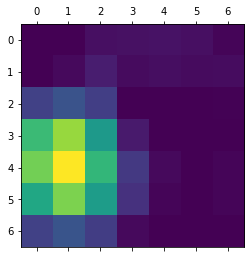

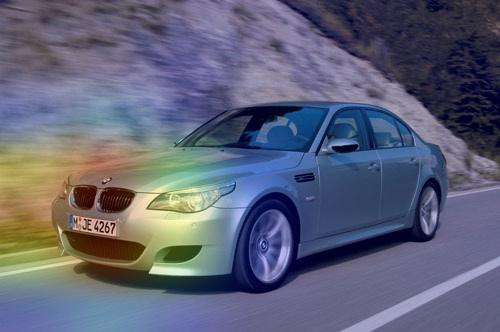

In [45]:
# Print what the top predicted class is

img_array = preprocess_input(get_img_array(img_path, size=img_size))

preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
# Display heatmap
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(img_path, heatmap)





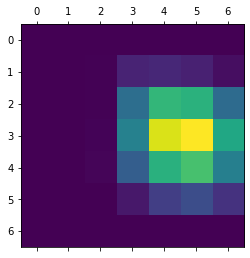

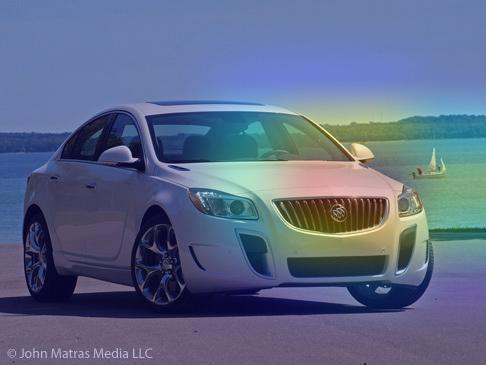

In [46]:



img_path = "/content/car_data/car_data/train/Buick Regal GS 2012/06787.jpg"
img_array = preprocess_input(get_img_array(img_path, size=img_size))

preds = model.predict(img_array)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(img_path, heatmap)

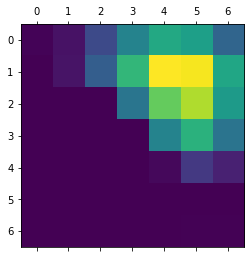

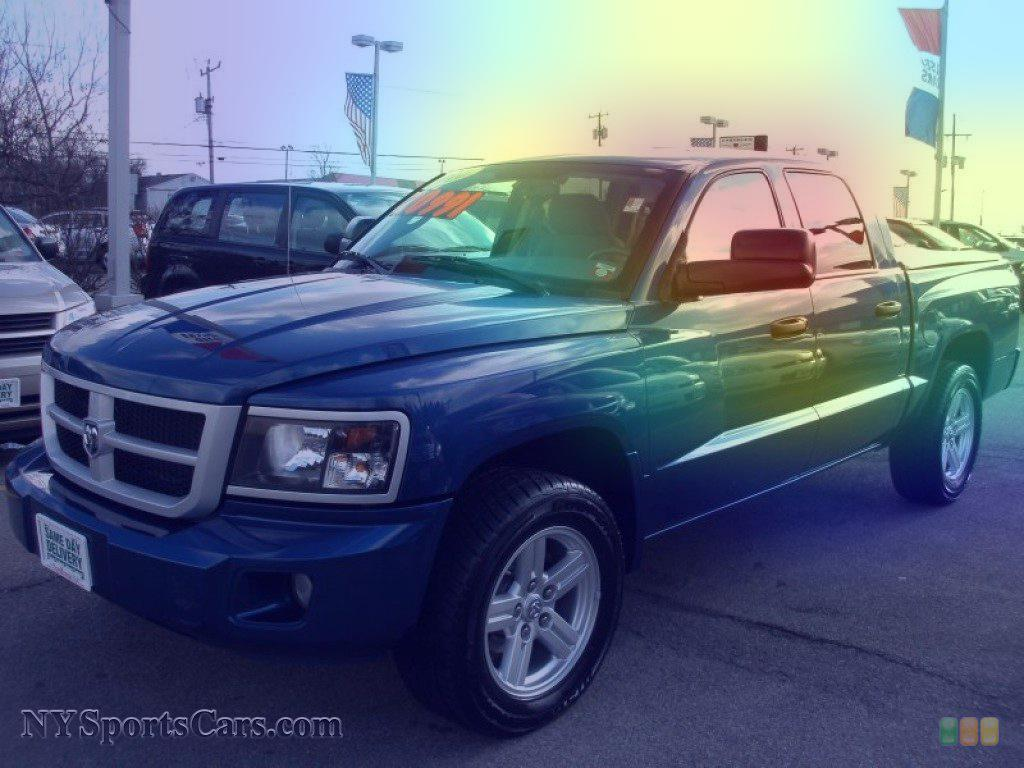

In [47]:


img_path = "/content/car_data/car_data/train/Dodge Dakota Crew Cab 2010/05653.jpg"
img_array = preprocess_input(get_img_array(img_path, size=img_size))

preds = model.predict(img_array)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(img_path, heatmap)



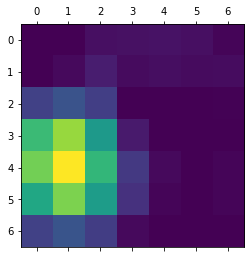

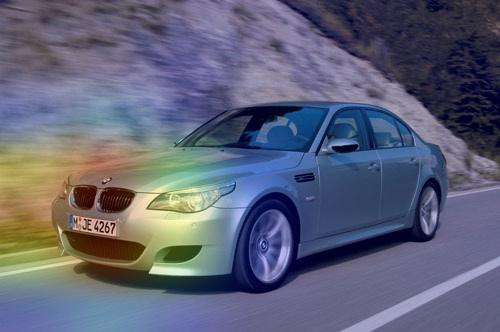

In [48]:

img_path = "/content/car_data/car_data/train/BMW M5 Sedan 2010/05706.jpg"
img_array = preprocess_input(get_img_array(img_path, size=img_size))

preds = model.predict(img_array)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(img_path, heatmap)
